In [1]:
import optuna
from optuna import Trial

from math import sqrt
from typing import Tuple, List

import numpy as np
import pandas as pd
from mordred import Calculator, descriptors
#import openbabel
from openbabel import pybel
from PyBioMed.PyMolecule.fingerprint import CalculatePubChemFingerprint,CalculateECFP2Fingerprint
from rdkit import Chem
from rdkit.Chem.rdchem import Atom
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc 
from sklearn.metrics import precision_recall_curve


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as G_Loader 
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import BatchNorm


# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
import torch

import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim
import torch.nn.functional as F # activation function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as V_Loader # dataset management
%run ./graph_feature.ipynb 
%run ./dataset_processing.ipynb 

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
k = 10
final_clean_desc_train=[]
final_clean_desc_val=[]
for i in range(k):
    final_clean_desc_train.append(np.load('final_clean_desc_train'+ str(i)+'.npy'))
    final_clean_desc_val.append(np.load('final_clean_desc_val' +str(i)+'.npy'))
final_clean_desc_test = np.load('final_clean_desc_test.npy')

In [3]:
final_clean_fingerp_train=[]
final_clean_fingerp_val=[]
for i in range(k):
    final_clean_fingerp_train.append(np.load('final_clean_fingerp_train'+ str(i)+'.npy'))
    final_clean_fingerp_val.append(np.load('final_clean_fingerp_val' +str(i)+'.npy'))

final_clean_fingerp_test = np.load('final_clean_fingerp_test.npy')

In [4]:
train_idx = np.load('train_indices.npy')
val_idx = np.load('val_indices.npy')
test_idx = np.load('test_indices.npy')

In [5]:
# load structured graph data
data_list_train=[]
for i in range(k):
    one_fold= []
    for idx in range(train_idx[i]):
        one_graph_data =torch.load(f"data_train_{i}/tensor{idx}.pt")
        one_fold.append(one_graph_data)
    data_list_train.append(one_fold)

In [6]:
data_list_val=[]
for i in range(k):
    one_fold= []
    for idx in range(val_idx[i]):
        one_graph_data =torch.load(f"data_val_{i}/tensor{idx}.pt")
        one_fold.append(one_graph_data)
    data_list_val.append(one_fold)

In [7]:
data_list_test =[]
for idx in range(test_idx):
    one_graph_data =torch.load(f"data_test/tensor{idx}.pt")
    data_list_test.append(one_graph_data)

In [8]:
# load the output label 
total_train_targets =[]
total_validation_targets =[]
total_test_targets=[]
for i in range(k):
    total_train_targets.append(np.load('total_train_targets'+ str(i)+'.npy'))
    total_validation_targets.append(np.load('total_validation_targets' +str(i)+'.npy'))

total_test_targets= np.load('total_test_targets.npy')

In [9]:
# create dataloader for training (graph data)
#======================================================================================
list_data_graph_train =[]
list_data_graph_val =[]
for data_train, data_val in zip(data_list_train, data_list_val):
    train_loader = G_Loader(dataset = data_train, batch_size = 500)
    val_loader = G_Loader(dataset = data_val, batch_size = 500)
    list_data_graph_train.append(train_loader)
    list_data_graph_val.append(val_loader)
# define loss function


In [10]:
# create dataloader for training (vector data)
#======================================================================================
list_data_desc_train =[]
list_data_desc_val =[]
for data_train, data_val in zip(final_clean_desc_train, final_clean_desc_val):
    train_loader = V_Loader(dataset = data_train, batch_size = 500)
    val_loader = V_Loader(dataset = data_val, batch_size = 500)
    list_data_desc_train.append(train_loader)
    list_data_desc_val.append(val_loader)

In [11]:
# create dataloader for training (vector data)
#======================================================================================
list_data_fingerp_train =[]
list_data_fingerp_val =[]
for data_train, data_val in zip(final_clean_fingerp_train, final_clean_fingerp_val):
    train_loader = V_Loader(dataset = data_train, batch_size = 500)
    val_loader = V_Loader(dataset = data_val, batch_size = 500)
    list_data_fingerp_train.append(train_loader)
    list_data_fingerp_val.append(val_loader)

In [12]:
#criterion = torch.nn.CrossEntropyLoss()
#define the loss function 
criterion = torch.nn.BCELoss()

In [13]:
def train_1(train_g_loader,train_v_loaderB,train_v_loaderC, combined_model, optimizer):
    combined_model.train()
    
    for data_X1, data_X2, data_X3 in zip(train_g_loader, train_v_loaderB,train_v_loaderC):  # Iterate in batches over the training dataset.
        out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                             torch.tensor(data_X2, dtype=torch.float32),torch.tensor(data_X3, dtype=torch.float32))  # Perform a single forward pass.
        
        y_t = data_X1.y.type(torch.FloatTensor)
        loss = criterion(out[:,0], y_t)  # Compute the loss.
        #print(k)
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss, combined_model, optimizer

In [14]:
def validation_1(val_g_loader,val_v_loaderB,val_v_loaderC, combined_model):
    for data_X1, data_X2, data_X3 in zip(val_g_loader, val_v_loaderB,val_v_loaderC): # Iterate in batches over the training dataset.
        out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                             torch.tensor(data_X2, dtype=torch.float32),torch.tensor(data_X3, dtype=torch.float32))  # Perform a single forward pass.
        
        y_t = data_X1.y.type(torch.FloatTensor)
        val_loss = criterion(out[:,0], y_t)  # Compute the loss.
        
    return val_loss

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

# performances visualization 
import matplotlib.pyplot as plt
#import seaborn as sns
import statistics
from prettytable import PrettyTable
%run ./my_performances.ipynb 


def test_1(g_loader,v_loaderB,v_loaderC, combined_model):
    combined_model.eval()
    list_pred =[]
    list_targets =[]
    correct = 0
    for data_X1, data_X2, data_X3 in zip(g_loader, v_loaderB,v_loaderC):  # Iterate in batches over the training/test dataset.
            out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                                 torch.tensor(data_X2, dtype=torch.float32),torch.tensor(data_X3, dtype=torch.float32))
            out_1 = out[:,0]
            
            list_pred.append(out_1.item())
            list_targets.append(data_X1.y.item())
    return list_pred, list_targets 

def test_2(g_loader,v_loaderB,v_loaderC, combined_model):
    combined_model.eval()
    list_pred =[]
    list_targets =[]
    correct = 0
    for data_X1, data_X2, data_X3 in zip(g_loader, v_loaderB,v_loaderC):  # Iterate in batches over the training/test dataset.
            out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                                 torch.tensor(data_X2, dtype=torch.float32),torch.tensor(data_X3, dtype=torch.float32))
            out_1 = out[:,0]
            
            list_pred = list_pred + out_1.tolist()
            list_targets= list_targets + data_X1.y.tolist()
    return list_pred, list_targets 


# used to count the train accuracy ,and validation accuracy when in the training mode 
def test(g_loader,v_loaderB,v_loaderC, combined_model):
    combined_model.eval()

    correct = 0
    for data_X1, data_X2, data_X3 in zip(g_loader, v_loaderB,v_loaderC):  # Iterate in batches over the training/test dataset.
            out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                                 torch.tensor(data_X2, dtype=torch.float32),torch.tensor(data_X3, dtype=torch.float32))
            out_1 = out[:,0]
            for i,value in enumerate(out_1) :
                if value > 0.5 :
                    out_1[i] = 1
                else : out_1[i] = 0
            pred = out_1  # Use the class with highest probability.
            correct += int((pred == data_X1.y).sum())  # Check against ground-truth labels.
    return correct / len(g_loader.dataset)  # Derive ratio of correct predictions.

In [16]:
def get_optimizer(gnn_model, learning_rate, optimizer_type,decay):
    if optimizer_type==1:
        optimizer = torch.optim.SGD(gnn_model.parameters(), lr=learning_rate, momentum=0.9)
    if optimizer_type==2:
        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=learning_rate, weight_decay =decay)
    if optimizer_type ==3 :
        optimizer = torch.optim.Adamax(gnn_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
        
    return optimizer

In [17]:
class modelA1(torch.nn.Module):
    def __init__(self, hidden_channels1,hidden_channels2, num_node_features,heads1,
                 heads2,dropout_rateA,dropout_rateB,dropout_rateC,dense_layer1):
        super(modelA1, self).__init__()
        
        torch.manual_seed(12345)
        self.conv1 = GATConv(num_node_features, hidden_channels1,heads1)
        self.conv2 = GATConv(hidden_channels1*heads1,hidden_channels2, heads2)
        
        self.bn1 = BatchNorm (hidden_channels1*heads1)
        self.bn2 = BatchNorm (hidden_channels2*heads2)
        
        self.dropoutA = dropout_rateA
        self.dropoutB = dropout_rateB
        self.dropoutC = dropout_rateC
        self.lin1 = Linear(hidden_channels2*heads2,dense_layer1)
        self.lin2=  Linear(dense_layer1,1)
        
    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=self.dropoutA , training=self.training)
        x = x.relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index)
        
        x = F.dropout(x, p=self.dropoutB , training=self.training)
        x = x.relu()
        x = self.bn2(x)   
      # 
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.lin1(x)
        x = F.dropout(x, p=self.dropoutC , training=self.training)
        x = x.relu()
        x = self.lin2(x)
        return torch.sigmoid(x)

class modelB1(torch.nn.Module):
    def __init__(self, input_features, output_features,dropout_rateB1,dropout_rateB2, dense_layer1):
        super(modelB1, self).__init__()
        self.lin1 = nn.Linear(input_features,dense_layer1)
      
        self.lin2 = nn.Linear(int(dense_layer1), int(dense_layer1/2))
        self.lin3 = nn.Linear(int(dense_layer1/2), int(dense_layer1/2))
        self.lin4 = nn.Linear(int(dense_layer1/2), output_features)
        
        self.bn1 = nn.BatchNorm1d(int(dense_layer1))
        self.bn2 = nn.BatchNorm1d(int(dense_layer1/2))
        self.bn3 = nn.BatchNorm1d(int(dense_layer1/2))
        self.dropoutB1 = dropout_rateB1
        self.dropoutB2 = dropout_rateB2
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
       
        x = F.dropout(x, p= self.dropoutB1, training=self.training)
        x = x.relu()
  #      
        x = self.lin2(x)
        x = self.bn2(x)   
        x = F.dropout(x, p= self.dropoutB2, training=self.training)
        x = x.relu()
  #      
        x = self.lin3(x)
        x = self.bn3(x)   
        x = x.relu()
        x = self.lin4(x)
        return torch.sigmoid(x)
        
class Combined_model(nn.Module):
    def __init__(self, modelA, modelB, modelC,dense_layer,act_func):
        super(Combined_model, self).__init__()
        self.model_1 = modelA
        self.model_2 = modelB
        self.model_3 = modelC
        self.act     =act_func
        self.lin1 = Linear(3,dense_layer)
        self.lin2 = Linear(dense_layer,1)
        
#        self.bn1 = nn.BatchNorm1d(int(total_input_features))
#        self.dropoutC = dropout_rateC
        
    def forward(self, x1,edge_index, batch, x2,x3):
        xa = self.model_1(x1, edge_index, batch) # x1 node features in graph
        xb = self.model_2(x2)  # x2 is a vector features
        xc = self.model_3(x3)
        x = torch.cat((xa, xb), dim=1)
        x = torch.cat((x, xc), dim=1)
#        x = self.bn1(x)
         # 3. Apply a final classifier
        x = self.lin1(x)
#        x = F.dropout(x, p= self.dropoutC, training=self.training)
#        x = torch.sigmoid(x)
        if self.act == 0 :
            x = x.relu()
        else: 
            x = torch.sigmoid(x)
        x = self.lin2(x)
        return torch.sigmoid(x)

In [20]:
# best hyperparameter for GNN 
my_hyper_GNN= my_hyper=my_hyper={'hidden_channels1': 112, 
 'hidden_channels2': 112,
 'heads1': 10, 
 'heads2': 10,
 'optimizer_type': 2, 
 'dropout_rateA': 0.1875877723990742,
 'dropout_rateB': 0.16097942424559475, 
 'dropout_rateC': 0.13247000729523636, 
 'learning_rate': 0.0001262534912805999, 
 'dense_layer1': 54,
 'decay': 0.0005717698923332719}

# best hyperparameter for Descriptor
my_hyper_desc =  {'optimizer_type': 3, 
                  'dense_layer1': 112, 
                  'dropout_rateB1': 0.41981209308537915, 
                  'dropout_rateB2': 0.35205533233977115, 
                  'learning_rate': 0.00039906715464665515}


my_hyper_fingerp = {'optimizer_type': 3,
                    'dense_layer1': 116,
                    'dropout_rateB1': 0.19140697875883203,
                    'dropout_rateB2': 0.4378593600513469,
                    'learning_rate': 0.0005085512117234079}

my_hyper_combined ={'decay': 0.00026452278246868614,
                    'learning_rate': 0.0014300644727794959,
                    'dense_layer': 6, 
                    'act_func': 0}

In [24]:
# load all the model in the fold 
k =10
list_modelA = []
list_modelB = []
list_modelC = []
list_combined_model=[]
for i in range(k):
    
    hidden_channels1= my_hyper_GNN['hidden_channels1']
    hidden_channels2= my_hyper_GNN['hidden_channels2']
    num_node_features =79
    heads1=my_hyper_GNN['heads1']
    heads2=my_hyper_GNN['heads2']
    dropout_rateA=my_hyper_GNN['dropout_rateA']
    dropout_rateB=my_hyper_GNN['dropout_rateB']
    dropout_rateC=my_hyper_GNN['dropout_rateC']
    dense_layer1=my_hyper_GNN['dense_layer1']
    
    modelA= modelA1(hidden_channels1,hidden_channels2, num_node_features,heads1,heads2,dropout_rateA,dropout_rateB,dropout_rateC, dense_layer1)
    PATH = '0.78915model_GNN'+ str(i)+'.pth'
    modelA.load_state_dict(torch.load(PATH))
    
    for param in modelA.parameters():
        param.requires_grad = False

    input_features    = 146 # length of feature data vector 
    output_features   = 1
    
    optimizer_type =my_hyper_desc['optimizer_type']   
    dropout_rateB1 = my_hyper_desc['dropout_rateB1']
    dropout_rateB2 = my_hyper_desc['dropout_rateB2']
    learning_rate = my_hyper_desc['learning_rate']
    dense_layer1 =my_hyper_desc['dense_layer1']     
        
    modelB= modelB1(input_features, output_features,dropout_rateB1,dropout_rateB2, dense_layer1)
    PATH = 'model_Dense_desc'+ str(i)+'.pth'
    modelB.load_state_dict(torch.load(PATH))
    
    for param in modelB.parameters():
        param.requires_grad = False

    
    input_features  =36
    output_features =1
    optimizer_type =my_hyper_fingerp['optimizer_type']   
    dropout_rateB1 = my_hyper_fingerp['dropout_rateB1']
    dropout_rateB2 = my_hyper_fingerp['dropout_rateB2']
    #learning_rate = my_hyper_fingerp['learning_rate']
    dense_layer1 =my_hyper_fingerp['dense_layer1']    
    
    modelC= modelB1(input_features, output_features,dropout_rateB1,dropout_rateB2, dense_layer1)
    PATH = 'model_Dense_fingerp'+ str(i)+'.pth'
    modelC.load_state_dict(torch.load(PATH))
    
    for param in modelC.parameters():
        param.requires_grad = False

    #new_model = Combined_model(modelA, modelB, modelC,dense_layer1)
    list_modelA.append(modelA)
    list_modelB.append(modelB)
    list_modelC.append(modelC)
    
    dense_layer = my_hyper_combined['dense_layer']
    act_func= my_hyper_combined['act_func']

    combined_model   = Combined_model(list_modelA[i],list_modelB[i],list_modelC[i], dense_layer, act_func)
    PATH = '0.78641model_Hybrid'+ str(i)+'.pth'
    combined_model.load_state_dict(torch.load(PATH))
    
    list_combined_model.append(combined_model)

In [25]:
k=10 # number of fold 
    

list_data_vec_trainB = list_data_desc_train
list_data_vec_valB = list_data_desc_val


list_data_vec_trainC = list_data_fingerp_train
list_data_vec_valC = list_data_fingerp_val


In [36]:
# RUNNING THE 10 PRETRAINED MODEL USING INDEPENDENT DATA
#======================================================================
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]

g_test_loader = G_Loader(dataset = data_list_test, batch_size = 1)
v_test_loaderB = V_Loader(dataset = final_clean_desc_test, batch_size = 1)
v_test_loaderC = V_Loader(dataset = final_clean_fingerp_test, batch_size = 1)

for combined_model in list_combined_model:  
    list_pred, list_targets = test_1(g_test_loader,v_test_loaderB,v_test_loaderC, combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_test = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_test[1], total_performances_test[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.78641

In [37]:
import statistics
from prettytable import PrettyTable
perf = total_performances
model_title = 'Test Perf. hybrid model'
data_type ='graph-struct and vector'
Create_Tables(perf, model_title, data_type)

+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |        Data Type        | m_ACC |  m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Test Perf. hybrid model | graph-struct and vector | 0.786 | 0.768 | 0.805 | 0.573 | 0.854 |  0.572  |  0.854  |   0.786   |
+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |        Data Type        | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----

In [42]:
def plot_ROC( method, total_performances):
    i =0
    total_data_roc = total_performances[5]
    for data_roc in total_data_roc:
    # plot ROC 
        fpr,tpr = data_roc[0], data_roc[1]
        plt.plot(fpr,tpr,marker='.',linestyle='--', label=method+'_fold_'+ str(i)+ ' AUC(' +str(total_performances[4][i])+')' )
        i = i+1
# axis labels
    plt.plot([0,1],[0,1],marker='.',linestyle='--',color='k')
    plt.title('ROC Curve for ' + str(method))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
# show the legend
    plt.legend()
# show the plot
    plt.show()
    
def plot_PR(total_data_pr, method):
    i =0
    for data_pr in total_data_pr:
    # plot PR 
        prec,rec = data_pr[0], data_pr[1]
        plt.plot(rec,prec,marker='.',linestyle='--', label=method+'_fold_'+ str(i))
        i = i+1
# axis labels
    plt.plot([0,1],[1,0], marker='.',linestyle='--',color='k')
    plt.title('PR Curve for ' + str(method))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
# show the legend
    plt.legend()
# show the plot
    plt.show()

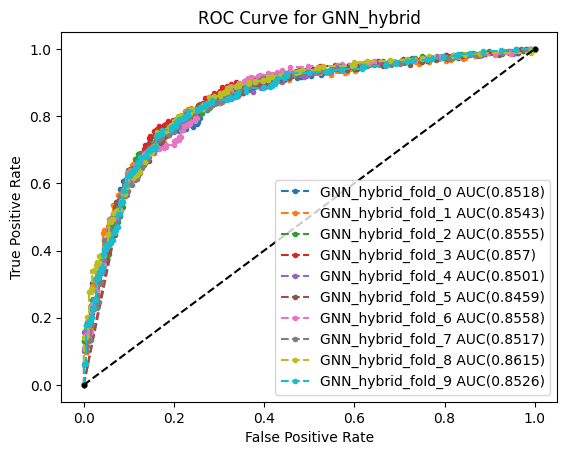

In [45]:
plot_ROC('GNN_hybrid', total_performances_test)

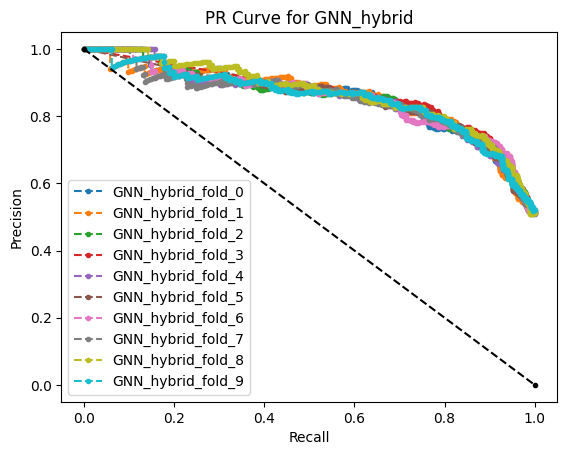

In [46]:
total_PR = total_performances_test[6]
plot_PR(total_data_pr=total_PR, method="GNN_hybrid")

In [38]:
# RUNNING THE 10 PRETRAINED MODEL USING INDEPENDENT DATA
#======================================================================
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]


for i,combined_model in enumerate(list_combined_model):  
    list_pred, list_targets = test_2(list_data_graph_train[i],list_data_vec_trainB[i],list_data_vec_trainC[i], combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_train = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_train[1] , total_performances_train[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.91866

In [39]:
import statistics
from prettytable import PrettyTable
perf = total_performances_train
model_title = 'Train Perf. hybrid model'
data_type ='graph-struct and vector'
Create_Tables(perf, model_title, data_type)

+--------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name        |        Data Type        | m_ACC |  m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+--------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Train Perf. hybrid model | graph-struct and vector | 0.919 | 0.915 | 0.922 | 0.837 | 0.975 |  0.837  |  0.975  |   0.919   |
+--------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
+--------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name        |        Data Type        | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+--------------------------+-------------------------+-------+-------+-------+-------+-------+---------+-------

In [40]:
# RUNNING THE 10 PRETRAINED MODEL USING INDEPENDENT DATA
#======================================================================
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]


for i,combined_model in enumerate(list_combined_model):  
    list_pred, list_targets = test_2(list_data_graph_val[i],list_data_vec_valB[i],list_data_vec_valC[i], combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_val = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_val[1] , total_performances_val[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.7719

In [41]:
import statistics
from prettytable import PrettyTable
perf = total_performances_val
model_title = 'Val. Perf. hybrid model'
data_type ='graph-struct and vector'
Create_Tables(perf, model_title, data_type)

+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |        Data Type        | m_ACC |  m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Val. Perf. hybrid model | graph-struct and vector | 0.772 | 0.762 | 0.782 | 0.545 | 0.844 |  0.544  |  0.844  |   0.772   |
+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |        Data Type        | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+-------------------------+-------------------------+-------+-------+-------+-------+-------+---------+---------+-----

In [ ]:
#    optimizer_type = trial.suggest_int('optimizer_type',1,3,step=1)
    optimizer_type = 2
    decay = trial.suggest_uniform('decay',  0.0001, 0.001)
    learning_rate = trial.suggest_uniform('learning_rate', 0.001, 0.002)
    dense_layer = trial.suggest_int('dense_layer',3,10, step=1) 
    act_func = trial.suggest_int('act_func',0,1,step=1)
    
    
    #total_history_train_loss=[]
    #total_history_val_loss=[]
    #total_history_train_acc=[]
    #total_history_val_acc=[]
    list_trained_model =[]
    for i in range(k):
      
            combined_model   = Combined_model(list_modelA[i],list_modelB[i],list_modelC[i], dense_layer, act_func)
            optimizer = get_optimizer(combined_model, learning_rate, optimizer_type,decay)
   
            history_train_loss=[]
            history_val_loss=[]
            history_train_acc=[]
            history_val_acc=[]
        
            for epoch in range(1, 100):
            
                
                train_loss,combined_model, optimizer = train_1(list_data_graph_train[i],list_data_vec_trainB[i],list_data_vec_trainC[i],
                                                           combined_model,optimizer)
                val_loss                             = validation_1(list_data_graph_val[i],list_data_vec_valB[i],list_data_vec_valC[i],
                                                                combined_model) 
        
                train_acc                            = test(list_data_graph_train[i],list_data_vec_trainB[i],list_data_vec_trainC[i],combined_model)
                val_acc                              = test(list_data_graph_val[i],list_data_vec_valB[i],list_data_vec_valC[i], combined_model)
        
           
            
                history_train_loss.append(train_loss.item())
                history_val_loss.append(val_loss.item())
                history_train_acc.append(train_acc)
                history_val_acc.append(val_acc)
        
                print(f'Fold: {i}')
                print(f'Epoch: {epoch:03d}, Train Loss:, {train_loss.item():.4f}')
                print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')
                print(f'Epoch: {epoch:03d}, val Loss:, {val_loss.item():.4f}')
                print(f'Epoch: {epoch:03d}, val Acc: {val_acc:.4f}')
                print(" ")
            total_history_train_loss.append(history_train_loss)
            total_history_val_loss.append(history_val_loss)
            total_history_train_acc.append(history_train_acc)
            total_history_val_acc.append(history_val_acc)

            list_trained_model.append(combined_model)
    # RUNNING THE 10 PRETRAINED MODEL USING INDEPENDENT DATA